# Intro Task, Object Localization

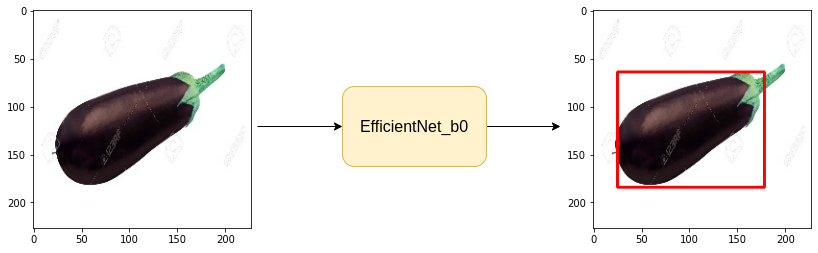

In [1]:
# install libraries/packages/modules

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-69dx5how
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-69dx5how
  Resolved https://github.com/albumentations-team/albumentations to commit 66212d77a44927a29d6a0e81621d3c27afbd929c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
pip install albucore==0.0.24


  Using cached albucore-0.0.24-py3-none-any.whl.metadata (5.3 kB)
Using cached albucore-0.0.24-py3-none-any.whl (15 kB)
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.28
    Uninstalling albucore-0.0.28:
      Successfully uninstalled albucore-0.0.28


In [3]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

fatal: destination path 'object-localization-dataset' already exists and is not an empty directory.


In [4]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [5]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [6]:
# vars and pars
# defining paths
#starting with CSV file
CSV_FILE = '/content/object-localization-dataset/train.csv'
DATA_DIR = '/content/object-localization-dataset/'

#DEVICE = 'cuda'
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16 # updaet after this number of samples
IMG_SIZE = 140

LR = 0.01
EPOCHS = 40
MODEL_NAME = 'efficientnet_b0'

NUM_COR = 4

In [7]:
df = pd.read_csv(CSV_FILE)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


# Understand the dataset

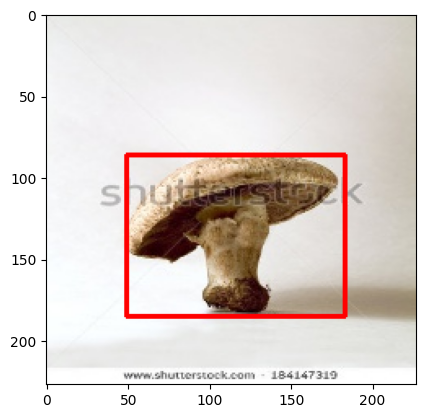

In [8]:
# plot some images from dataset

row = df.iloc[2]
img = cv2.imread(DATA_DIR + row.img_path) # cv2 read images in BGR we have to convert to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#plot
pt1 = (row.xmin, row.ymin) # bottom left corner
pt2 = (row.xmax, row.ymax) # top right corner
# bounding box
bnd_box_img = cv2.rectangle(img, pt1, pt2, (255, 0, 0), 2)
plt.imshow(bnd_box_img)

In [9]:
# split dataset into training and validation
# we can take validation set as test set
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state = 42)


# Augmentations

In [10]:
import albumentations as A

In [11]:
train_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p = 0.5),
    A.VerticalFlip(p = 0.5),
    A.Rotate()
], bbox_params = A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels']))

valid_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    #A.HorizontalFlip(p = 0.5),
    #A.VerticalFlip(p = 0.5),
    #A.Rotate()
], bbox_params = A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels']))

# Create Custom Dataset

In [12]:
# create custom dataset so that pytorch can read the images
#image and bounding box pair
class ObjLocDataset(torch.utils.data.Dataset):

  #constructor
  def __init__(self, df, augmentations = None):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    xmin = row.xmin
    ymin = row.ymin
    xmax = row.xmax
    ymax = row.ymax

    bbox = [[xmin, ymin, xmax, ymax]] # creating bounding box

    img_path = DATA_DIR + row.img_path
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if self.augmentations:
      data = self.augmentations(image = img, bboxes = bbox, class_labels = [None]) # send three parameters to the Albumentations pipeline
      # extract image and bounding box according to the key
      img = data['image'] # take out the transformed image
      bbox = data['bboxes'][0] # It’s a list of four numbers — the coordinates of the red box after transformations.

    # convert image to pytorch tensor
    img = torch.from_numpy(img).permute(2, 0, 1) / 225.0 #(h, w, c) -> (c, h, w)
    bbox = torch.Tensor(bbox)

    return img, bbox

In [13]:
# create train set and validset using the class we defined for PyTorch
trainset = ObjLocDataset(train_df, train_augs)
validset = ObjLocDataset(valid_df, valid_augs)


In [14]:
# see number of examples in the validset and trainset
print(f"total number of trainset : {len(trainset)}")
print(f"total number of validset : {len(validset)}")

total number of trainset : 148
total number of validset : 38


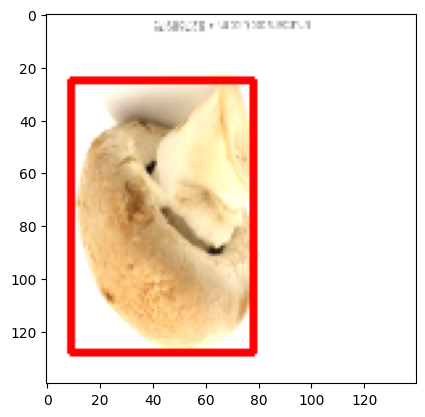

In [15]:
img, bbox = trainset[100]

xmin, ymin, xmax, ymax = bbox # unpacking bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [16]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = torch.utils.data.DataLoader(validset, batch_size = BATCH_SIZE, shuffle = False)

In [17]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [18]:
for images, bboxes in trainloader:
  break; #Immediately stops the loop after the first batch.


print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [19]:
from torch import nn
import timm

In [20]:
# Import PyTorch's neural network module base class
from torch import nn
# Import timm library (contains pretrained CNN architectures like ResNet, EfficientNet, etc.)
import timm


# Define a custom neural network model for object localization
class ObjLocModel(nn.Module):

    # Constructor: defines what layers/components this model has
    def __init__(self):
        # Initialize the parent nn.Module class
        super(ObjLocModel, self).__init__()

        # Load a pretrained CNN backbone (e.g., ResNet, EfficientNet, etc.)
        # pretrained=True means it starts with weights learned on ImageNet
        # num_classes=4 means the network’s output layer will predict 4 numbers (e.g., x, y, w, h bounding box), [xmin, ymin, xmax, ymax],
        self.backbone = timm.create_model(MODEL_NAME, pretrained=True, num_classes=4)


    # Forward pass: defines how input data flows through the model
    #the forward() function is where the CNN actually does its purpose.
    def forward(self, images, gt_bboxes=None):
        # Pass the batch of input images through the CNN backbone
        # → produces predicted bounding boxes (the CNN’s output feature maps flattened to coordinates)
        bboxes = self.backbone(images) # returns four numbers (predictions)

        # If ground-truth bounding boxes are provided (training mode)
        if gt_bboxes != None:
            # Compute Mean Squared Error loss between predicted and true bounding boxes
            # This is the loss computation step of the training loop
            loss = nn.MSELoss()(bboxes, gt_bboxes)
            return bboxes, loss

        # If no ground-truth boxes (inference mode), just return predictions
        return bboxes


In [21]:
model = ObjLocModel()
#transfer our model to DEVICE
model.to(DEVICE);

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [22]:
random_img = torch.rand(1, 3, 140, 140).to(DEVICE)
model(random_img).shape

torch.Size([1, 4])

# Create Train and Eval Function

In [23]:
# for all batches
def train_fn(model, dataloader, optimizer):
  total_loss = 0.0
  model.train()

  for data in tqdm(dataloader):
    images, gt_bboxes = data
    images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)
    bboxes, loss = model(images, gt_bboxes)
    #gradient step
    optimizer.zero_grad()
    loss.backward() # calculate gradient
    optimizer.step() # will find thupdate the weights and biases

    # sum total losses
    total_loss += loss.item()

    return total_loss / len(dataloader)


In [24]:
#
def eval_fn(model, dataloader):
  total_loss = 0.0
  model.eval()

  with torch.no_grad():
    for data in tqdm(dataloader):
      images, gt_bboxes = data
      images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)
      #
      bboxes, loss = model(images, gt_bboxes)

      # sum total losses
      total_loss += loss.item()

      return total_loss / len(dataloader)


#Training Loop

In [25]:
# write training loop
#declaring the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = LR) # LR defined in configuration


#

In [27]:
best_valid_loss = np.inf
for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer)
  valid_loss = eval_fn(model, validloader)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("weights are saved")
    best_valid_loss = valid_loss

  print(f"Epoch : {i+1} train loss : {train_loss} valid_loss : {valid_loss}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights are saved
Epoch : 1 train loss : 589.76748046875 valid_loss : 101877.47916666667


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 2 train loss : 309.07001953125 valid_loss : 849166.5833333334


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 3 train loss : 239.4983642578125 valid_loss : 28464733.333333332


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 4 train loss : 162.2753662109375 valid_loss : 6885088.0


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 5 train loss : 160.3409423828125 valid_loss : 32867717.333333332


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 6 train loss : 119.6073974609375 valid_loss : 228087978.66666666


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 7 train loss : 66.6255615234375 valid_loss : 511060736.0


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 8 train loss : 41.68824157714844 valid_loss : 591516032.0


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 9 train loss : 43.33587646484375 valid_loss : 1816119978.6666667


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 10 train loss : 31.03792724609375 valid_loss : 618999381.3333334


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 11 train loss : 27.925186157226562 valid_loss : 60053813.333333336


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 12 train loss : 29.175836181640626 valid_loss : 11312869.333333334


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 13 train loss : 24.686300659179686 valid_loss : 6492902.666666667


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 14 train loss : 38.27273254394531 valid_loss : 3069871.6666666665


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 15 train loss : 31.00152587890625 valid_loss : 1953999.5


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 16 train loss : 27.529080200195313 valid_loss : 1206850.3333333333


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 17 train loss : 22.887753295898438 valid_loss : 1519045.0


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 18 train loss : 24.908021545410158 valid_loss : 3000522.6666666665


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 19 train loss : 27.487039184570314 valid_loss : 1915308.3333333333


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 20 train loss : 21.72112579345703 valid_loss : 972326.8333333334


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 21 train loss : 14.667236328125 valid_loss : 568133.375


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 22 train loss : 23.286093139648436 valid_loss : 447803.9166666667


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 23 train loss : 21.83490905761719 valid_loss : 332045.625


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 24 train loss : 21.42713317871094 valid_loss : 181866.08333333334


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 25 train loss : 20.088685607910158 valid_loss : 109346.08333333333


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights are saved
Epoch : 26 train loss : 21.56607666015625 valid_loss : 81795.484375


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights are saved
Epoch : 27 train loss : 23.099484252929688 valid_loss : 54553.260416666664


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights are saved
Epoch : 28 train loss : 19.372665405273438 valid_loss : 39744.989583333336


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights are saved
Epoch : 29 train loss : 28.399899291992188 valid_loss : 26376.5625


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights are saved
Epoch : 30 train loss : 24.220672607421875 valid_loss : 15153.080729166666


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights are saved
Epoch : 31 train loss : 18.30315704345703 valid_loss : 7718.19140625


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights are saved
Epoch : 32 train loss : 15.326315307617188 valid_loss : 4904.382161458333


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights are saved
Epoch : 33 train loss : 22.65504608154297 valid_loss : 4134.826822916667


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 34 train loss : 22.473678588867188 valid_loss : 4656.960611979167


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 35 train loss : 17.268336486816406 valid_loss : 4518.867838541667


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 36 train loss : 14.591267395019532 valid_loss : 4452.813151041667


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights are saved
Epoch : 37 train loss : 9.062116241455078 valid_loss : 3599.6012369791665


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights are saved
Epoch : 38 train loss : 11.275242614746094 valid_loss : 2288.8616536458335


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights are saved
Epoch : 39 train loss : 21.615908813476562 valid_loss : 2175.6783854166665


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 40 train loss : 11.37060546875 valid_loss : 2762.9677734375


#Inference

In [28]:
import utils # contains compare function

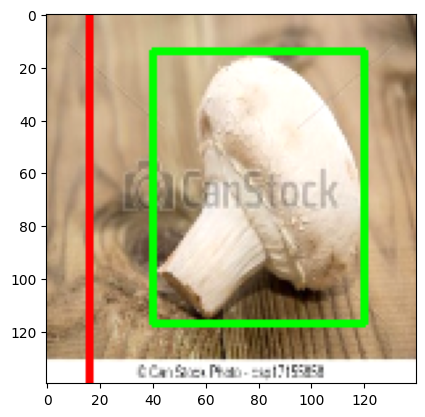

In [32]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

with torch.no_grad():
  image, gt_bbox = validset[23] # (c, h, v) order for tensors
  image = image.unsqueeze(0).to(DEVICE) # (bs, c, h, w)
  out_bbox = model(image)

  utils.compare_plots(image, gt_bbox, out_bbox)